In [ ]:
# default_exp gbe.rtt.scoring

# Risk Taking Task (RTT)

<div>
    <p style="float: left;"><img src="images/gambling_task.png" alt="Drawing" style="width: 200px; border-right:30px solid white"/>
    <ol style="padding-left:240px">
        <li>Participants chose between gambles and certain choices.</li>
        <li>Three trial types:
            <ul>
                <li>Win/nothing vs. certain win (win trials)</li>
                <li>Loss/nothing vs. certain loss (loss trials)</li>
                <li>Win/loss vs. nothing (mixed trials)</li>
            </ul>
        </li>
        <li>For each type, we calculate the percentage gambles.</li>
    </ol>

</div>


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)

In [ ]:
#export
from trr265.gbe.rtt.data_provider import RTTDataProvider
import pandas as pd
import numpy as np
from scipy import stats
import biuR.wrapper

## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

In [ ]:
# Getting raw data
dp = RTTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_rtt_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")

## Example data

In [ ]:
example = df.query("gbe_index=='b001_001' and trial_type == 'win'")[['participant','session_number','trial_type','gambled']]
display(example.reset_index(drop=True))
print("The participants' percentage gambles in this session is %.2f%%"%(example.gambled.mean()*100))

,participant,session_number,trial_type,gambled
0,b001,1.0,win,True
1,b001,1.0,win,False
2,b001,1.0,win,True
3,b001,1.0,win,True
4,b001,1.0,win,False
5,b001,1.0,win,False
6,b001,1.0,win,False
7,b001,1.0,win,False
8,b001,1.0,win,True
9,b001,1.0,win,True


The participants' percentage gambles in this session is 54.55%


## Aggregation methods

### Mean method
Here we simply calculate the percentage gambles for each session and trial type.

In [ ]:
#export
def get_percentage_gamble(df):
    percentage_gamble = df.groupby(['gbe_index','trial_type'])['gambled'].mean().unstack()
    percentage_gamble = percentage_gamble.add_prefix('perc_gamble_')
    return percentage_gamble

In [ ]:
perc_gamble = get_percentage_gamble(df)

#### Distribution

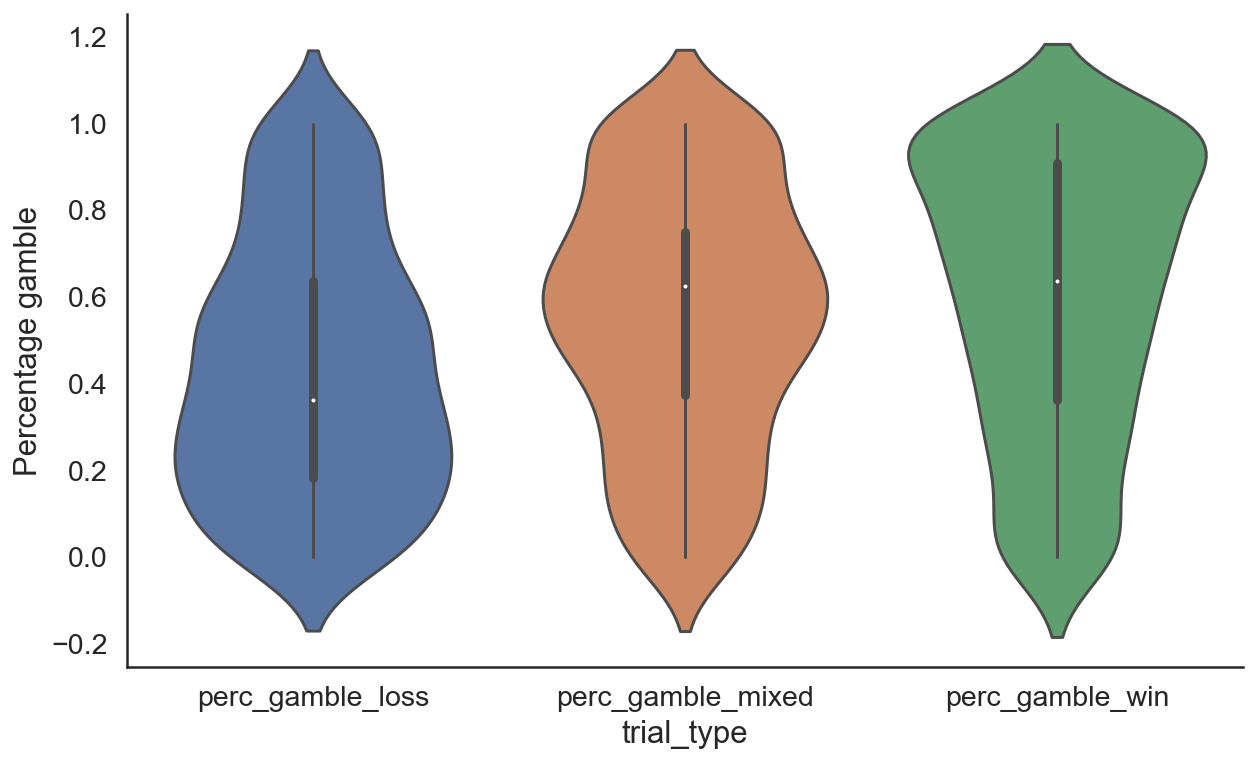

In [ ]:
fix, ax = plt.subplots(figsize = (10,6))
sns.violinplot(x="trial_type", y="value", data=pd.melt(perc_gamble), ax = ax)
ax.set_ylabel("Percentage gamble")
sns.despine()

## Trial level analyses

### Trial types and sessions modelled separately (check)
Here we run the model `glmer(success ~ 1 + (1 | participant)` separately for each session and trial type.  This way of modelling the data should be closely related to the aggregation method and therefore serves mostly as a check.

In [ ]:
#export
def get_perc_gamble_predicted_sep_r(df):
    R = biuR.wrapper.R()
    p = R("""
    library(lmerTest)
    library(ggeffects)
    # Running the model
    control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))
    m = glmer(is_gamble ~ 1 + (1 | participant), data=df, family=binomial, control = control, na.action = na.exclude)
    # Extracting predicted values
    ggpredict(m, terms=c("participant"), type="re",ci.lvl = NA)
    """,push=dict(df=df))
    return p

def get_perc_gamble_predicted_sep(df):
    df['is_gamble'] = df.gambled.astype(int)
    dfs = []
    # Looping through trial types
    for trial_type in ['win','loss','mixed']:
        session_dfs = []
        # Looping through sessions
        for session in [2,1]:
            # Extracting data for specific session and trial type
            _df = df.query('(session_number==@session) and (trial_type==@trial_type)')
            # Predicting scores
            predicted = get_perc_gamble_predicted_sep_r(_df)
            # Labeling variables
            predicted.columns = ['participant','perc_gamble_sep_%s'%trial_type,'session']
            predicted['session'] = session
            predicted['gbe_index'] = predicted.participant.astype(str) + '_%03d'%session
            predicted = predicted.set_index('gbe_index')['perc_gamble_sep_%s'%trial_type].to_frame()
    # Combining everything into one dataframe
            session_dfs.append(predicted)       
        dfs.append(pd.concat(session_dfs))
    perc_gamble_sep = pd.concat(dfs, axis = 1)     
    return perc_gamble_sep

In [ ]:
perc_gamble_predicted_sep = get_perc_gamble_predicted_sep(df)

R[write to console]: Lade nötiges Paket: lme4

R[write to console]: Lade nötiges Paket: Matrix

R[write to console]: 
Attache Paket: ‘lmerTest’


R[write to console]: Das folgende Objekt ist maskiert ‘package:lme4’:

    lmer


R[write to console]: Das folgende Objekt ist maskiert ‘package:stats’:

    step




#### Distribution

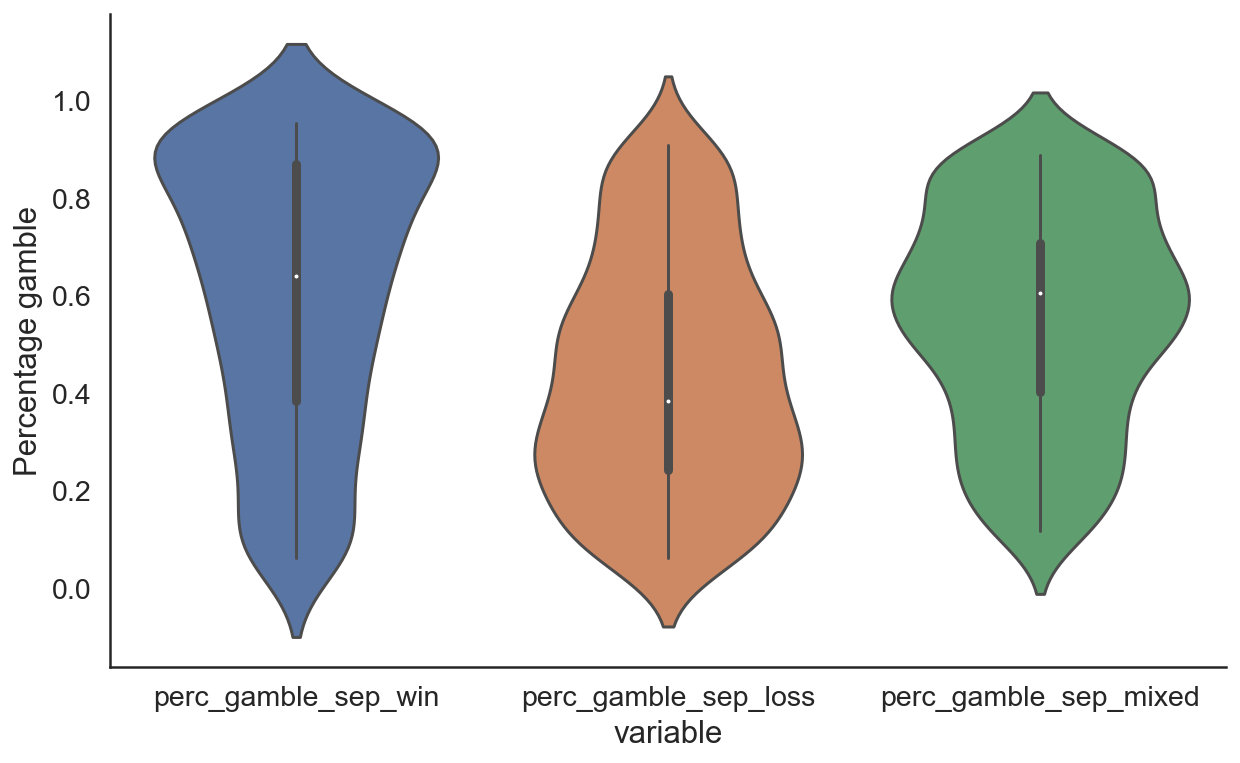

In [ ]:
fix, ax = plt.subplots(figsize = (10,6))
sns.violinplot(x="variable", y="value", data=pd.melt(perc_gamble_predicted_sep), ax = ax)
ax.set_ylabel("Percentage gamble")
sns.despine()

#### Correlation with aggregated score

In [ ]:
def jitter(arr):
    return arr + np.random.randn(len(arr)) * arr.std()/10

def jittered_regplot(**kwargs):
    df, x, y = kwargs['data'],kwargs['x'], kwargs['y']
    df[x+'_j'] = jitter(df[x])
    df[y+'_j'] = jitter(df[y])
    kwargs['x'] = x+'_j'
    kwargs['y'] = y+'_j'
    kwargs['data'] = df
    ax = sns.regplot(**kwargs)
    return ax

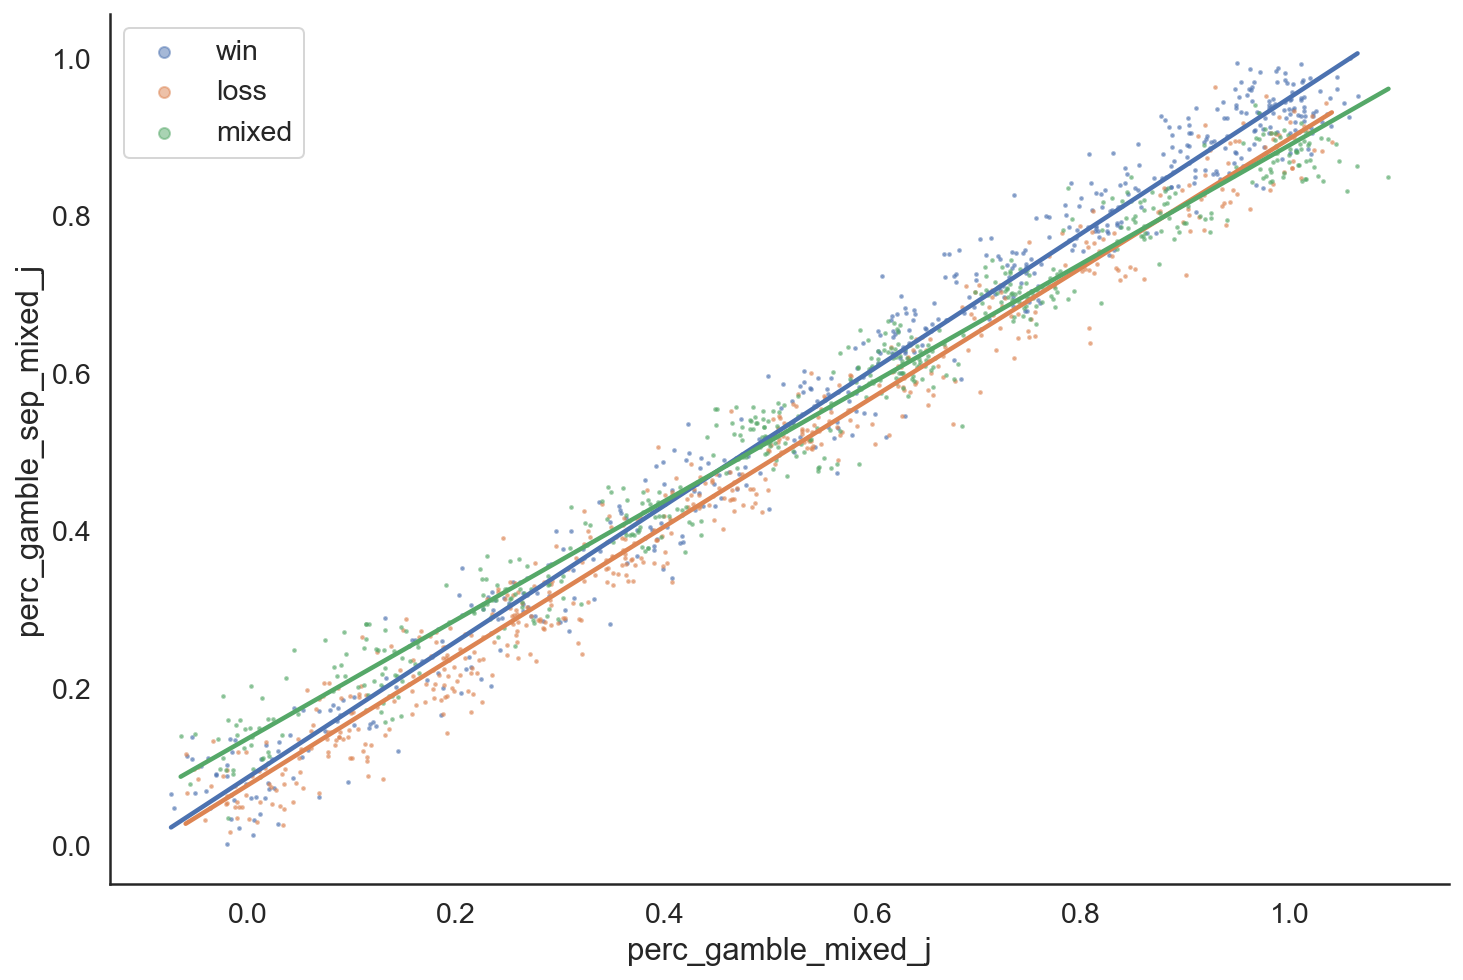

In [ ]:
_df = pd.concat([perc_gamble_predicted_sep, perc_gamble], axis = 1)
fix, ax = plt.subplots(1,1, figsize = (12,8))

for trial_type in ['win','loss','mixed']:
    jittered_regplot(x = 'perc_gamble_%s'%trial_type, y = 'perc_gamble_sep_%s'%trial_type, data = _df, ci = None, label = trial_type,scatter_kws = {'s':2, 'alpha':.5})
#ax.set_xlabel('Implied percentage correct (predicted)')
#ax.set_ylabel('Implied percentage correct (aggregated)')
lgnd = plt.legend()
for i in range(3):
    lgnd.legendHandles[i]._sizes = [30]

> As expected, these scores correlate highly with aggregated scores.

In [ ]:
from scipy.stats import pearsonr
for trial_type in ['win','loss','mixed']:
    print(trial_type)
    print(pearsonr(_df['perc_gamble_%s'%trial_type], _df['perc_gamble_sep_%s'%trial_type]))

win
(0.9994063454315026, 0.0)
loss
(0.9980735163971843, 0.0)
mixed
(0.9981940586234628, 0.0)


### Trial types modeled separately but sessions modelled combined
Next, we run the model `glmer(is_gamble ~ 1 + (1 | participant/session)` separately for trial types but together for each session.  This model has the advantage that it integrates more data into the estimation of each session.

In [ ]:
#export
def get_perc_gamble_predicted_joint_r(df):    
    R = biuR.wrapper.R()
    p = R("""
    library(lmerTest)
    library(ggeffects)
    # Running the model
    control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))
    m = glmer(is_gamble ~ 1 + (1 | participant/session), data=df, family=binomial, control = control, na.action = na.exclude)
    # Extracting predicted values
    ggpredict(m, terms=c("participant","session"), type="re",ci.lvl = NA)
    """,push=dict(df=df))
    
    m = R("""m""")
    return p, m

def get_perc_gamble_predicted_joint(df):
    df['is_gamble'] = df.gambled.astype(int)
    dfs = []
    ms = {}
    # Looping through trial types
    for trial_type in ['win','loss','mixed']:
        # Extracting data for specific trial type
        _df = df.query('(trial_type==@trial_type)')
        _df['session'] = _df.session_number.astype(str) # making session a factor 
        # Predicting scores
        predicted, m = get_perc_gamble_predicted_joint_r(_df)
        # Labeling variables
        predicted.columns = ['participant','perc_gamble_joint_%s'%trial_type,'session']
        #predicted['session'] = session
        predicted['gbe_index'] = predicted.participant.astype(str) + predicted.session.apply(lambda x: '_%03d'%int(float(x))).astype(str)
        predicted = predicted.set_index('gbe_index')['perc_gamble_joint_%s'%trial_type].to_frame()
    # Combining everything into one dataframe
        dfs.append(predicted)
        ms[trial_type] = m
    perc_predicted_sep_trial = pd.concat(dfs, axis = 1)
    # Removing sessions that were not in initial dataframe
    perc_predicted_sep_trial = perc_predicted_sep_trial.loc[df.gbe_index.unique()]
    return perc_predicted_sep_trial, ms
    

In [ ]:
perc_gamble_predicted_joint, ms = get_perc_gamble_predicted_joint(df)

#### Correlation with last model

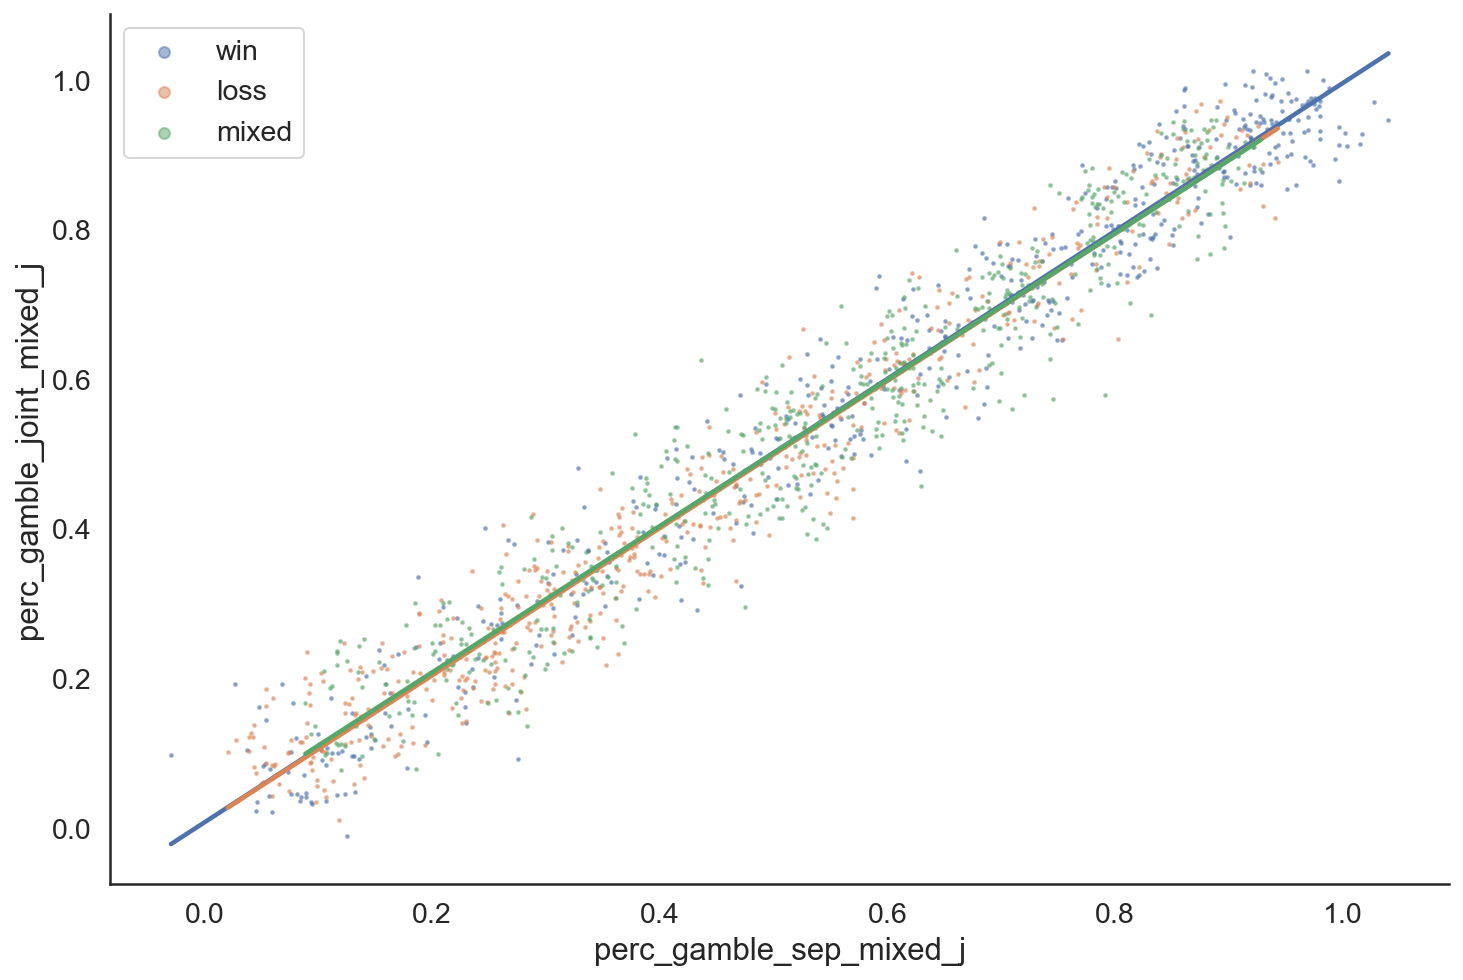

In [ ]:
_df = pd.concat([perc_gamble_predicted_sep, perc_gamble_predicted_joint], axis = 1)
fix, ax = plt.subplots(1,1, figsize = (12,8))

for trial_type in ['win','loss','mixed']:
    jittered_regplot(x = 'perc_gamble_sep_%s'%trial_type, y = 'perc_gamble_joint_%s'%trial_type, data = _df, ci = None, label = trial_type,scatter_kws = {'s':2, 'alpha':.5})
#ax.set_xlabel('Implied percentage correct predicted (sessions separate)')
#ax.set_ylabel('Implied percentage correct predicted (sessions together)')
lgnd = plt.legend()
for i in range(3):
    lgnd.legendHandles[i]._sizes = [30]

### Trial types and sessions modelled combined
ToDo (see WM task)

## Correlations between different scores

In [ ]:


def correl(df):
    df_corr = pd.DataFrame() # Correlation matrix
    df_p = pd.DataFrame()  # Matrix of p-values
    for x in df.columns:
        for y in df.columns:
            corr = stats.pearsonr(df[x], df[y])
            df_corr.loc[x,y] = corr[0]
            df_p.loc[x,y] = corr[1]
    return df_corr, df_p

def correlation_matrix(analysis_data, alpha = .01, bonferroni = False, size = (11,9), show_correl = True):

    if bonferroni:
        variables = len(analysis_data.columns)
        correction = ((variables * variables) - variables)/2
        alpha = alpha / correction

    df_corr, df_p = correl(analysis_data)
    sig = (df_p < alpha).replace({True:"*",False:""})
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    if show_correl:
        p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},
                   annot=df_corr.applymap(lambda x: '%.3f'%x),fmt = '')
    else:
         p1 = sns.heatmap(df_corr, mask=mask,cmap=cmap, center=0, vmax=1, vmin=-1,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},fmt = '')       
    #p1.text(len(df_corr)-1, 1, "Alpha = %g"%alpha, size='medium', color='black')
    p = df_p.unstack()
    p.index = ['*'.join(map(str,i)) for i in p.index.tolist()]
    p = p.to_dict()
    corr = df_corr.unstack()
    corr.index = ['*'.join(map(str,i)) for i in corr.index.tolist()]
    corr = corr.to_dict()

win


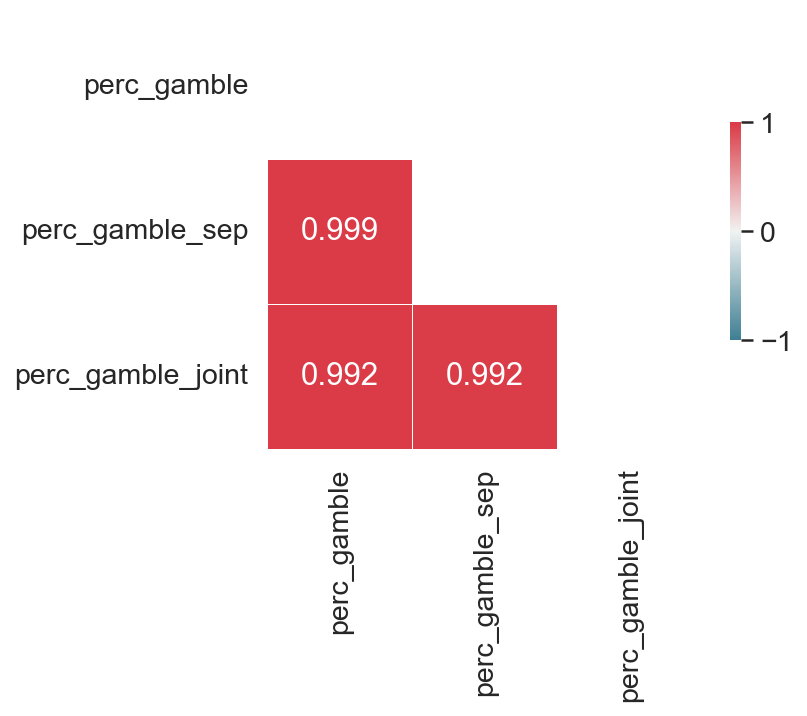

loss


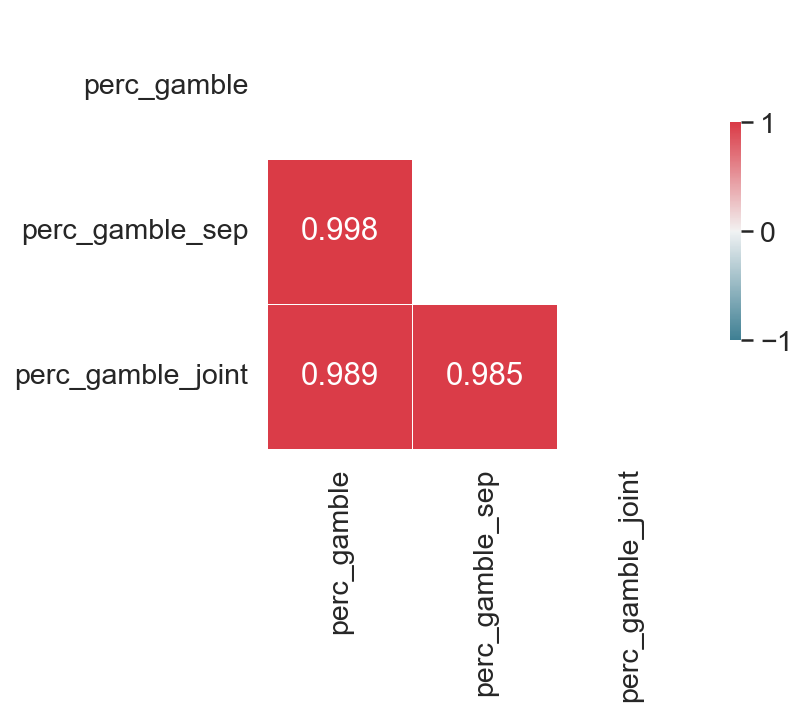

mixed


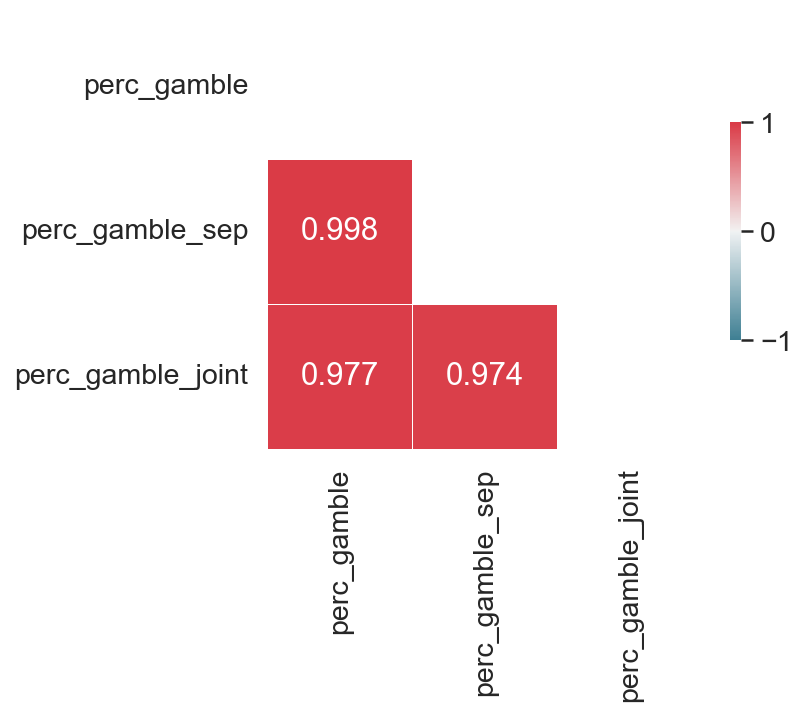

In [ ]:
def show_correlations():
    df = pd.concat([perc_gamble, perc_gamble_predicted_sep, perc_gamble_predicted_joint], axis = 1)
    
    for trial_type in ['win','loss','mixed']:
        print(trial_type)
        type_columns =[c for c in df.columns if trial_type in c]
        _df = df[type_columns]
        _df.columns = [c.replace(trial_type, '')[:-1] for c in _df.columns]
        correlation_matrix(_df, size = (5,4))
        plt.show()
show_correlations()

> Within trial types, correlations between different scores are high.

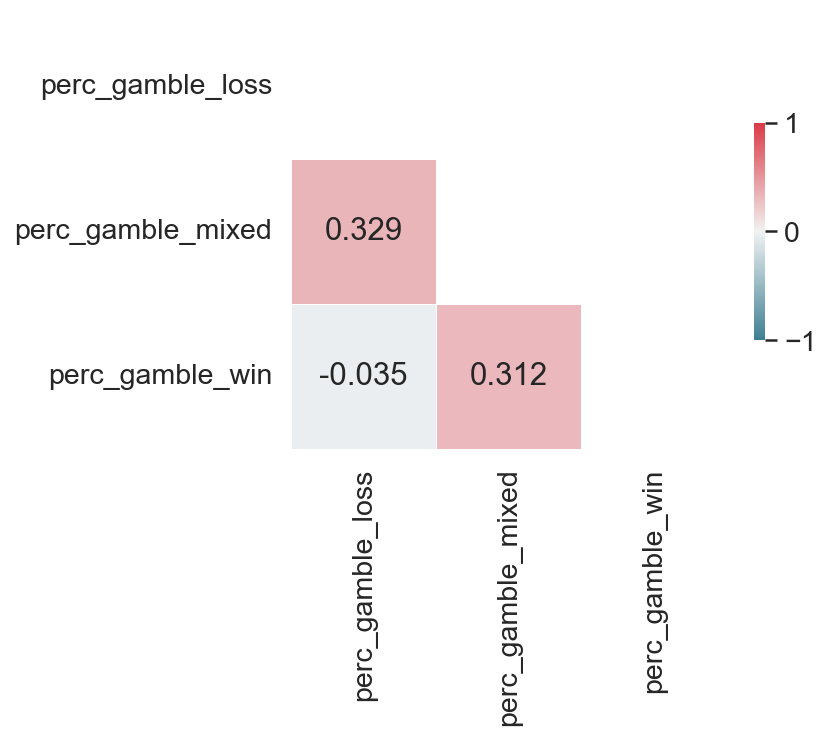

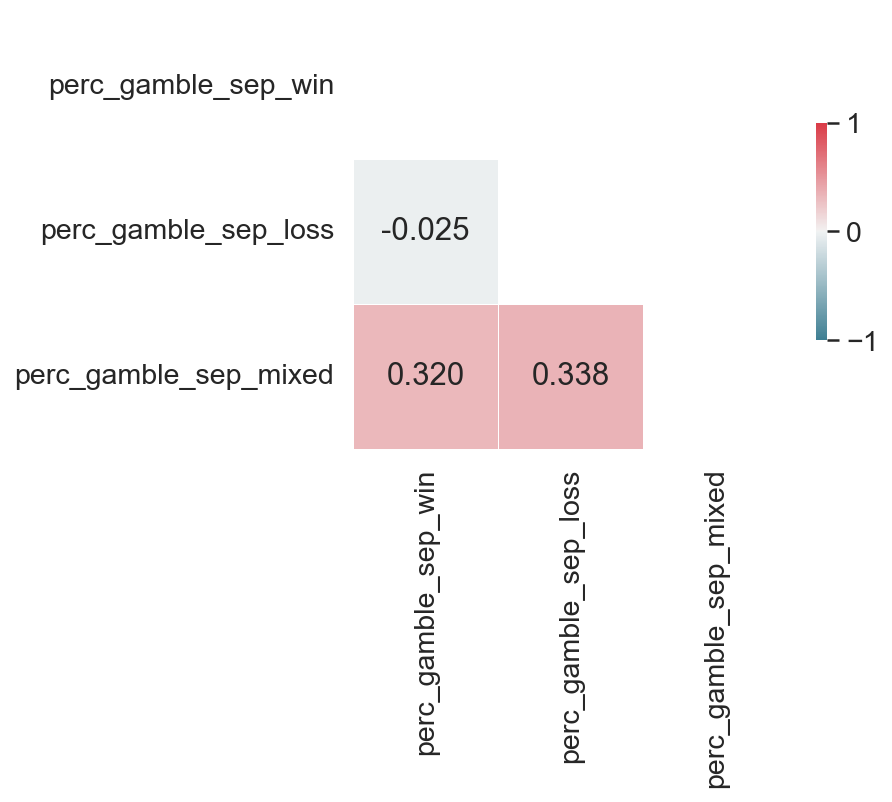

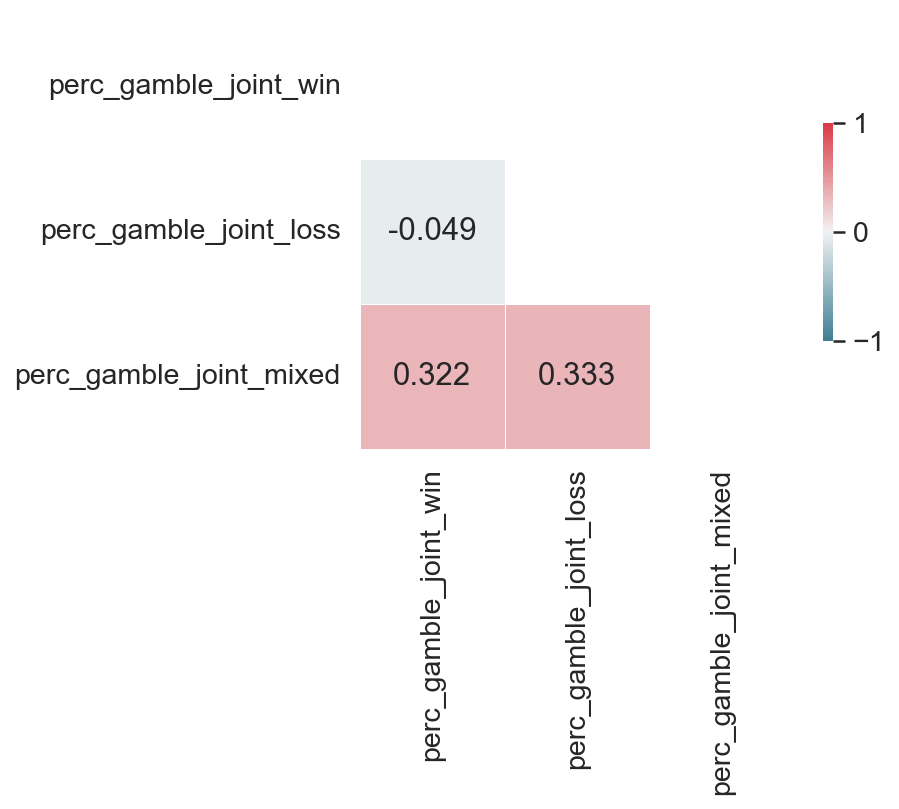

In [ ]:
for _df in [perc_gamble, perc_gamble_predicted_sep, perc_gamble_predicted_joint]:
    correlation_matrix(_df, size = (5,4))

> Correlations between trial types are low.

## Extracting data for computational modelling

In [ ]:
df = dp.get_gbe_data()

In [ ]:
df = df[df['RewardAndHappinessGame'].isna()==False]

In [ ]:
import re
def decode_gbe_string(s):
    """This function function turns one gbe output string into a dataframe"""
    def replace(g):
        return g.group(0).replace(',', '|')
    s = re.sub(r'\[.*?\]', replace, s) # The comma separated string can contain comma separated list items
    columns, df = s.replace('","',';').replace('"','').split('\n')
    
    df = pd.DataFrame([column for column in df.split(';')][:-1]).transpose()#.ffill().iloc[:-1]
    
    df.columns = [c for c in columns.split(',')[:-1]]
    return df

def decode_gbe_strings(df, column):
    '''This function turns all gbe output strings in a column into dataframes and concatenates them.'''
    df = df[~df[column].isna()] # Selecting non nan data
    #gbe_data = pd.concat(df.set_index(['participant','session_number'])[column].apply(self.decode_gbe_string).values, keys = df.index)
    #gbe_data = pd.concat(df[column].apply(self.decode_gbe_string).values)
    df = pd.concat(df[column].apply(decode_gbe_string).values, keys = df.index)
    df.index.rename('trial_number',level = 1, inplace = True)
    df = df.reset_index()
    df['trial_number'] = df.trial_number + 1
    df['timesPlayed'] = df.gbe_index.apply(lambda x: int(x.split('_')[1]))
    df['uid'] = df.gbe_index.apply(lambda x: int(x.split('_')[0][1:])).astype(int)
    df['site'] = df.gbe_index.apply(lambda x: x.split('_')[0][0]).replace({'b':1,'d':2,'m':3})
    return df

_df = decode_gbe_strings(df,'RewardAndHappinessGame')[['site','timestarted','uid','score','timesubmitted','timesPlayed','tr_spinnerwinamount','tr_spinnerloseamount','tr_choiceamount','tr_trialresult','tr_decisiontime','tr_spintime','tr_spinnerangle','tr_happiness','tr_happinesstime','tr_happinessstart','appversion']]

_df['age'] = ''
_df['gender'] = ''
_df['group'] = ''
_df['education'] = ''
_df['Tag1_konsum'] = ''
_df['Tag1_substanzeinfluss'] = ''
_df['empty1'] = ''
_df['empty2'] = ''

_df = _df[['age','gender','site','group','education','Tag1_konsum','Tag1_substanzeinfluss','empty1','empty2','timestarted','uid','score','timesubmitted','timesPlayed','tr_spinnerwinamount','tr_spinnerloseamount','tr_choiceamount','tr_trialresult','tr_decisiontime','tr_spintime','tr_spinnerangle','tr_happiness','tr_happinesstime','tr_happinessstart','appversion']]

In [ ]:
_df.to_excel('../data/processed/rtt_data.xlsx',header = False, index = False)